Task:
How can you harmonize new_meta to follow the curated_meta schema with minimum manual curation? You can sketch the overall process or select a specific attribute to demonstrate your idea.

In [55]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
# Load data
new_meta = pd.read_csv('new_meta.csv')
curated_meta = pd.read_csv('curated_meta.csv')

# take a look at the data
print(new_meta.head())
print(curated_meta.head())

        study_name sample_id           subject_id body_site  \
0  HanniganGD_2017  MG100208  HanniganGD_2017_A29     stool   
1  HanniganGD_2017  MG100207  HanniganGD_2017_A28     stool   
2  HanniganGD_2017  MG100206  HanniganGD_2017_A27     stool   
3  HanniganGD_2017  MG100205  HanniganGD_2017_A26     stool   
4  HanniganGD_2017  MG100204  HanniganGD_2017_A25     stool   

  antibiotics_current_use study_condition  disease   age  infant_age  \
0                      no         adenoma  adenoma  45.0         NaN   
1                      no         adenoma  adenoma  50.0         NaN   
2                      no         adenoma  adenoma  68.0         NaN   
3                      no         adenoma  adenoma  80.0         NaN   
4                      no         adenoma  adenoma  63.0         NaN   

  age_category  ... hla_dqa12 hla_dqa11 hla_drb11 zigosity brinkman_index  \
0        adult  ...       NaN       NaN       NaN      NaN            NaN   
1        adult  ...       NaN     

C:\Users\chang\AppData\Local\Temp\ipykernel_25964\3401034006.py:3: DtypeWarning: Columns (13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  curated_meta = pd.read_csv('curated_meta.csv')


In [43]:
duplicate_count = new_meta.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")
if duplicate_count == 0:
    print("→ No duplicate rows found.")

missing_per_col = new_meta.isna().sum()
total_missing = missing_per_col.sum()
print("\nNumber of missing values per column:")
print(missing_per_col)
print(f"→ Total missing values: {total_missing}")

Number of duplicate rows: 0
→ No duplicate rows found.

Number of missing values per column:
study_name                   0
sample_id                    0
subject_id                   0
body_site                    0
antibiotics_current_use    626
                          ... 
alcohol_numeric            707
breastfeeding_duration     571
formula_first_day          555
ALT                        707
eGFR                       707
Length: 141, dtype: int64
→ Total missing values: 83352


In [44]:
print("new_meta shape:", new_meta.shape)
print("new_meta info:")
new_meta.info()

print("curated_meta shape:", curated_meta.shape)
print("curated_meta info:")
curated_meta.info()

new_meta shape: (707, 141)
new_meta info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Columns: 141 entries, study_name to eGFR
dtypes: float64(112), int64(5), object(24)
memory usage: 778.9+ KB
curated_meta shape: (21881, 37)
curated_meta info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21881 entries, 0 to 21880
Data columns (total 37 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   study_name                               21881 non-null  object 
 1   sample_id                                21881 non-null  object 
 2   age_years                                13472 non-null  float64
 3   age_min                                  21880 non-null  float64
 4   age_max                                  21880 non-null  float64
 5   age_group                                21880 non-null  object 
 6   age_group_ontology_term_id               21880 non-nu

We can observe that new_meta contains many rows, but a significant number of them have null values.
Additionally, all the data follow a standardized pattern, suggesting that the dataset may have already undergone some cleaning.
Since this is an Exploratory Data Analysis (EDA) task, I will skip certain data-cleaning steps to focus on analysis.

In [45]:
# Drop all null columns, since they are not useful in this case, even if curated_meta has them, we can fill them with null
process_meta = new_meta.dropna(axis=1, how='all')
print("process_meta shape:", process_meta.shape)

process_meta shape: (707, 37)


If there are columns with the same name, we can directly use them but convert their format or terminology to match the curated_meta structure.
Note: In this step, we can leverage LLMs or sentence_transformers to identify additional columns with similar meanings through semantic matching.
However, if a column contains only simple categorical values like "yes/no" or short standardized codes (e.g., "USA," "CAN," "FIN"), a direct string match or a lookup table should be sufficient.
I will provide a detailed explanation of sentence_transformers usage in `automated_metadata_curation.ipynb`.

In [46]:
curated_columns = set(curated_meta.columns)
new_meta_columns = set(process_meta.columns)

common_columns = curated_columns.intersection(new_meta_columns)

print("\nCommon columns: ", len(common_columns))
for col in common_columns:
    if col not in ["sample_id", "study_name"]:
        print(col, "options:", new_meta[col].unique())


Common columns:  6
country options: ['CAN' 'USA' 'NLD' 'FIN']
antibiotics_current_use options: ['no' nan]
body_site options: ['stool']
disease options: ['adenoma' 'healthy' 'CRC' 'IBD']


In [47]:
# Fill in
process_meta = process_meta.copy()

# body_site
process_meta["body_site"] = "feces" # Since stool is the only body_site value in new_meta, and apparently equivalent to feces in curated_meta

# body_site_ontology_term_id
feces_id = curated_meta.loc[
    (curated_meta["body_site"] == "feces") & (curated_meta["body_site_ontology_term_id"].notna()),
    "body_site_ontology_term_id"
].head(1).iloc[0]
body_site_idx = process_meta.columns.get_loc("body_site")
process_meta.insert(
    body_site_idx + 1,
    "body_site_ontology_term_id",
    feces_id
)

# country
country_map = {
        'CAN': 'Canada',
        'FIN': 'Finland',
        'NLD': 'Netherlands',
        'USA': 'United States'
    }
process_meta["country"] = process_meta["country"].map(country_map)

# country_ontology_term_id
curated_country_map = curated_meta.dropna(subset=["country", "country_ontology_term_id"]) \
    .set_index("country")["country_ontology_term_id"].to_dict()
country_idx = process_meta.columns.get_loc("country")
process_meta.insert(
    country_idx + 1,
    "country_ontology_term_id",
    process_meta["country"].map(curated_country_map)
)

# antibiotics_current_use/sample_id/study_name: no need to fill in, since it's already same with curated_meta

# disease
disease_map = {
    'adenoma': 'Adenoma',
    'healthy': 'Healthy',
    'CRC': 'colorectal cancer',
    'IBD': 'Inflammatory Bowel Disease'
}
process_meta["disease"] = process_meta["disease"].map(disease_map)

# disease_ontology_term_id
curated_disease_map = curated_meta.dropna(subset=["disease", "disease_ontology_term_id"]) \
    .set_index("disease")["disease_ontology_term_id"].to_dict()
disease_idx = process_meta.columns.get_loc("disease")
process_meta.insert(
    disease_idx + 1,
    "disease_ontology_term_id",
    process_meta["disease"].map(curated_disease_map)
)
print(process_meta.head())


        study_name sample_id           subject_id body_site  \
0  HanniganGD_2017  MG100208  HanniganGD_2017_A29     feces   
1  HanniganGD_2017  MG100207  HanniganGD_2017_A28     feces   
2  HanniganGD_2017  MG100206  HanniganGD_2017_A27     feces   
3  HanniganGD_2017  MG100205  HanniganGD_2017_A26     feces   
4  HanniganGD_2017  MG100204  HanniganGD_2017_A25     feces   

  body_site_ontology_term_id antibiotics_current_use study_condition  disease  \
0             UBERON:0001988                      no         adenoma  Adenoma   
1             UBERON:0001988                      no         adenoma  Adenoma   
2             UBERON:0001988                      no         adenoma  Adenoma   
3             UBERON:0001988                      no         adenoma  Adenoma   
4             UBERON:0001988                      no         adenoma  Adenoma   

  disease_ontology_term_id   age  ...  born_method feeding_practice location  \
0               NCIT:C2855  45.0  ...          NaN    

In [48]:
# Sex
process_meta.rename(columns={"gender": "sex"}, inplace=True)
process_meta["sex"] = process_meta["sex"].str.lower().str.capitalize()

# sex_ontology_term_id
sex_map = curated_meta.dropna(subset=["sex", "sex_ontology_term_id"]).set_index("sex")["sex_ontology_term_id"].to_dict()
sex_idx = process_meta.columns.get_loc("sex")
process_meta.insert(
    sex_idx + 1,
    "sex_ontology_term_id",
    process_meta["sex"].map(sex_map)
)

In [49]:
# age
age_group_onto_map = curated_meta.dropna(subset=['age_group', 'age_group_ontology_term_id']) \
    .set_index('age_group')['age_group_ontology_term_id'].to_dict()

# generate age_years, age_min, age_max, age_group, age_group_ontology_term_id based on infant_age, age, and age_category.
def process_age(row):
    if pd.notna(row['infant_age']):
        age_years = row['infant_age'] / 365.0
        return (
            age_years,
            age_years,
            age_years,
            'Infant',
            age_group_onto_map['Infant']
        )

    if pd.notna(row['age']):
        if row['age_category'] == 'adult':
            return (
                row['age'],
                row['age'],
                row['age'],
                'Adult',
                age_group_onto_map['Adult']
            )
        elif row['age_category'] == 'senior':
            return (
                row['age'],
                row['age'],
                row['age'],
                'Elderly',
                age_group_onto_map['Elderly']
            )
        else:
            return (row['age'], row['age'], row['age'], np.nan, np.nan)

    if row['age_category'] == 'adult':
        return (
            np.nan,
            18,
            65,
            'Adult',
            age_group_onto_map['Adult']
        )
    elif row['age_category'] == 'senior':
        return (np.nan, np.nan, np.nan, 'Elderly', age_group_onto_map['Elderly'])

    return (np.nan, np.nan, np.nan, np.nan, np.nan)

age_cols = ['age_years', 'age_min', 'age_max', 'age_group', 'age_group_ontology_term_id']

process_meta[age_cols] = pd.DataFrame(
    process_meta.apply(process_age, axis=1).tolist(),
    columns=age_cols
)

print(process_meta[age_cols].head())


   age_years  age_min  age_max age_group age_group_ontology_term_id
0       45.0     45.0     45.0     Adult                NCIT:C49685
1       50.0     50.0     50.0     Adult                NCIT:C49685
2       68.0     68.0     68.0   Elderly                NCIT:C16268
3       80.0     80.0     80.0   Elderly                NCIT:C16268
4       63.0     63.0     63.0     Adult                NCIT:C49685


In [50]:
# control
control_map = {
        'control': 'Study Control',
        'adenoma': 'Case',
        'CRC': 'Case',
        'IBD': 'Case'
    }

process_meta['control'] = process_meta['study_condition'].map(control_map)

# control_ontology_term_id
control_idx = process_meta.columns.get_loc("control")
control_map = curated_meta.dropna(subset=["control", "control_ontology_term_id"]) \
    .set_index("control")["control_ontology_term_id"].to_dict()
process_meta.insert(
    control_idx + 1,
    "control_ontology_term_id",
    process_meta["control"].map(control_map)
)
print(process_meta.head())

        study_name sample_id           subject_id body_site  \
0  HanniganGD_2017  MG100208  HanniganGD_2017_A29     feces   
1  HanniganGD_2017  MG100207  HanniganGD_2017_A28     feces   
2  HanniganGD_2017  MG100206  HanniganGD_2017_A27     feces   
3  HanniganGD_2017  MG100205  HanniganGD_2017_A26     feces   
4  HanniganGD_2017  MG100204  HanniganGD_2017_A25     feces   

  body_site_ontology_term_id antibiotics_current_use study_condition  disease  \
0             UBERON:0001988                      no         adenoma  Adenoma   
1             UBERON:0001988                      no         adenoma  Adenoma   
2             UBERON:0001988                      no         adenoma  Adenoma   
3             UBERON:0001988                      no         adenoma  Adenoma   
4             UBERON:0001988                      no         adenoma  Adenoma   

  disease_ontology_term_id   age  ...  fobt breastfeeding_duration  \
0               NCIT:C2855  45.0  ...    no                    N

Actually, I think identifying the target_condition in new_meta is not easy.

However, I was able to figure it out.
By analyzing the dataset, I first noticed that some target_condition values contain disease names, yet the disease column is labeled "Healthy." At the same time, the control column indicates that these samples are study controls.
This suggests that target_condition refers to the research focus on certain diseases (or possibly individuals carrying related genes).

The most relevant columns for this would be:
study_name
PMID (since research papers often include the disease as a keyword)
NCBI (as the associated genes may be linked to the disease)

There are only 3 studies in this dataset. HanniganGD_2017 is about colorectal cancer, VilaAV_2018 is abuot IBD (and don't have healthy cases), and YassourM_2018 about Mother-to-Child Bacterial Transmission (all cases are healthy).
For VilaAV_2018, target_condition is same as disease, `Inflammatory Bowel Disease`. target_condition_ontology_term_id is `NCIT:C3138`
For HanniganGD_2017, some cases have Adenoma other than colorectal cancer, but we can find some similarly to YachidaS_2019 in curated meta, so target_condition is `colorectal cancer;Adenoma`, target_condition_ontology_term_id is `EFO:0005842;NCIT:C2855`
For YassourM_2018, same as AsnicarF_2017 in curated meta, so target_condition is `human gut microbiome`, target_condition_ontology_term_id is `OHMI:0000020`

If this process needs to be repeated in the future, I believe transformers alone may not be suitable because target_condition is somewhat abstract and difficult to match accurately (especially for control groups rather than experimental groups).

In [51]:
# target_condition
target_condition_map = {
    'HanniganGD_2017': 'colorectal cancer;Adenoma',
    'VilaAV_2018': 'Inflammatory Bowel Disease',
    'YassourM_2018': 'human gut microbiome'
}
process_meta['target_condition'] = process_meta['study_name'].map(target_condition_map)

# target_condition_ontology_term_id
target_condition_idx = process_meta.columns.get_loc("target_condition")
target_condition_map = {
    'colorectal cancer;Adenoma': 'EFO:0005842;NCIT:C2855',
    'Inflammatory Bowel Disease': 'NCIT:C3138',
    'human gut microbiome': 'OHMI:0000020'
}
process_meta.insert(
    target_condition_idx + 1,
    "target_condition_ontology_term_id",
    process_meta["target_condition"].map(target_condition_map)
)
print(process_meta.head())

        study_name sample_id           subject_id body_site  \
0  HanniganGD_2017  MG100208  HanniganGD_2017_A29     feces   
1  HanniganGD_2017  MG100207  HanniganGD_2017_A28     feces   
2  HanniganGD_2017  MG100206  HanniganGD_2017_A27     feces   
3  HanniganGD_2017  MG100205  HanniganGD_2017_A26     feces   
4  HanniganGD_2017  MG100204  HanniganGD_2017_A25     feces   

  body_site_ontology_term_id antibiotics_current_use study_condition  disease  \
0             UBERON:0001988                      no         adenoma  Adenoma   
1             UBERON:0001988                      no         adenoma  Adenoma   
2             UBERON:0001988                      no         adenoma  Adenoma   
3             UBERON:0001988                      no         adenoma  Adenoma   
4             UBERON:0001988                      no         adenoma  Adenoma   

  disease_ontology_term_id   age  ...  formula_first_day age_years age_min  \
0               NCIT:C2855  45.0  ...                NaN

In [52]:
# westernized
process_meta['westernized'] = process_meta.get("non_westernized").apply(
    lambda x: "Yes" if pd.notna(x) and x == "no" else ("No" if pd.notna(x) else pd.NA)
)
print(process_meta.head())

        study_name sample_id           subject_id body_site  \
0  HanniganGD_2017  MG100208  HanniganGD_2017_A29     feces   
1  HanniganGD_2017  MG100207  HanniganGD_2017_A28     feces   
2  HanniganGD_2017  MG100206  HanniganGD_2017_A27     feces   
3  HanniganGD_2017  MG100205  HanniganGD_2017_A26     feces   
4  HanniganGD_2017  MG100204  HanniganGD_2017_A25     feces   

  body_site_ontology_term_id antibiotics_current_use study_condition  disease  \
0             UBERON:0001988                      no         adenoma  Adenoma   
1             UBERON:0001988                      no         adenoma  Adenoma   
2             UBERON:0001988                      no         adenoma  Adenoma   
3             UBERON:0001988                      no         adenoma  Adenoma   
4             UBERON:0001988                      no         adenoma  Adenoma   

  disease_ontology_term_id   age  ...  age_years age_min age_max age_group  \
0               NCIT:C2855  45.0  ...       45.0    45.0

In [53]:
# Choose some columns to keep
fields_to_include = [
    "fobt",
    "infant_age",
    "BMI",
    "DNA_extraction_kit",
    "pregnant",
    "family_role",
    "born_method",
    "feeding_practice",
    "birth_weight",
    "gestational_age",
    "disease_subtype"
]

def create_unmetadata(row):
    unmetadata_parts = []
    
    for field in fields_to_include:
        value = row.get(field, pd.NA)
        
        if pd.isna(value) or str(value).strip() == "":
            continue
        
        if field == "fobt":
            unmetadata_parts.append(f"fobt:{value}")
        elif field == "infant_age":
            if pd.api.types.is_number(value) and value < 90:
                unmetadata_parts.append("uncurated_metadata:infant_age was given as < 90")
            else:
                unmetadata_parts.append(f"infant_age:{value}")
        else:
            unmetadata_parts.append(f"{field}:{value}")

    if not unmetadata_parts:
        return pd.NA

    return ";".join(unmetadata_parts)

process_meta["unmetadata"] = process_meta.apply(create_unmetadata, axis=1)
print(process_meta.head())

        study_name sample_id           subject_id body_site  \
0  HanniganGD_2017  MG100208  HanniganGD_2017_A29     feces   
1  HanniganGD_2017  MG100207  HanniganGD_2017_A28     feces   
2  HanniganGD_2017  MG100206  HanniganGD_2017_A27     feces   
3  HanniganGD_2017  MG100205  HanniganGD_2017_A26     feces   
4  HanniganGD_2017  MG100204  HanniganGD_2017_A25     feces   

  body_site_ontology_term_id antibiotics_current_use study_condition  disease  \
0             UBERON:0001988                      no         adenoma  Adenoma   
1             UBERON:0001988                      no         adenoma  Adenoma   
2             UBERON:0001988                      no         adenoma  Adenoma   
3             UBERON:0001988                      no         adenoma  Adenoma   
4             UBERON:0001988                      no         adenoma  Adenoma   

  disease_ontology_term_id   age  ...  age_min age_max age_group  \
0               NCIT:C2855  45.0  ...     45.0    45.0     Adult  

In [ ]:
curated_fields = curated_meta.columns.tolist()
new_meta_curated = pd.DataFrame()
for field in curated_fields:
    if field in process_meta.columns:
        new_meta_curated[field] = process_meta[field]
    else:
        new_meta_curated[field] = pd.NA

new_meta_curated.to_csv("harmonized_new_meta.csv", index=False, na_rep="NA")

Visualization

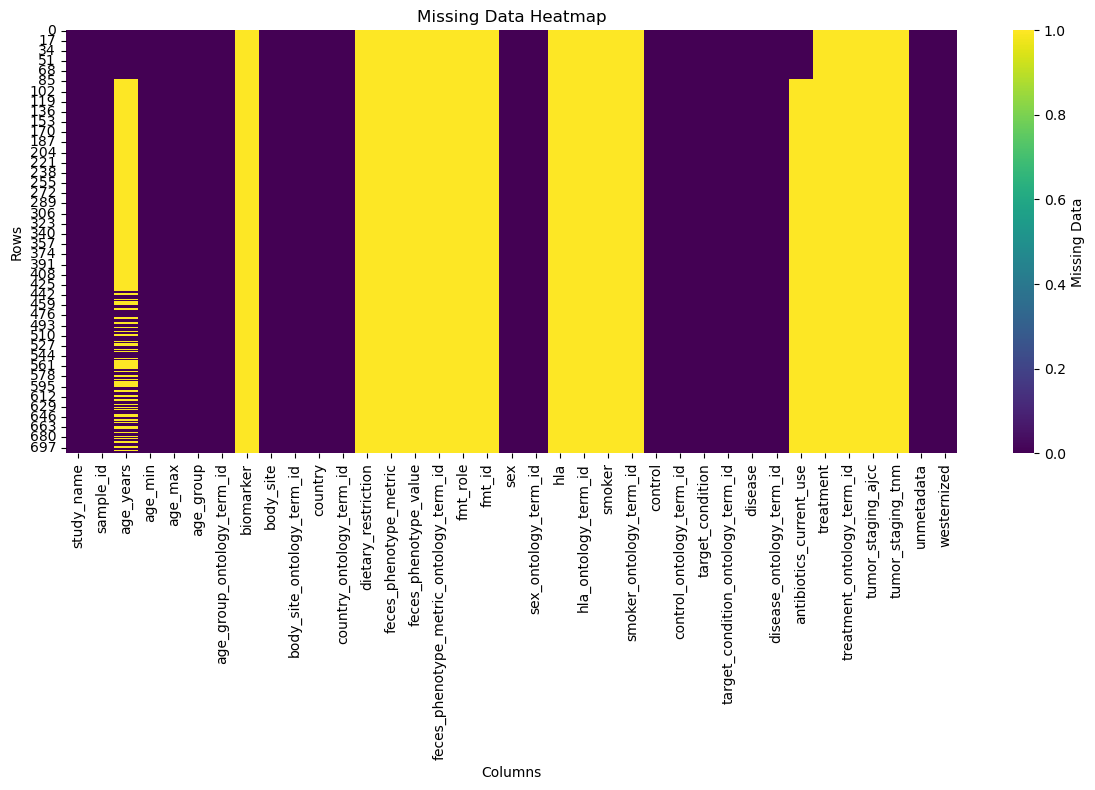

In [56]:
harmonized_meta = pd.read_csv("harmonized_new_meta.csv")

missing_data = harmonized_meta.isnull()

plt.figure(figsize=(12, 8))
sns.heatmap(missing_data, cmap="viridis", cbar_kws={'label': 'Missing Data'})
plt.title("Missing Data Heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.tight_layout()
plt.show()

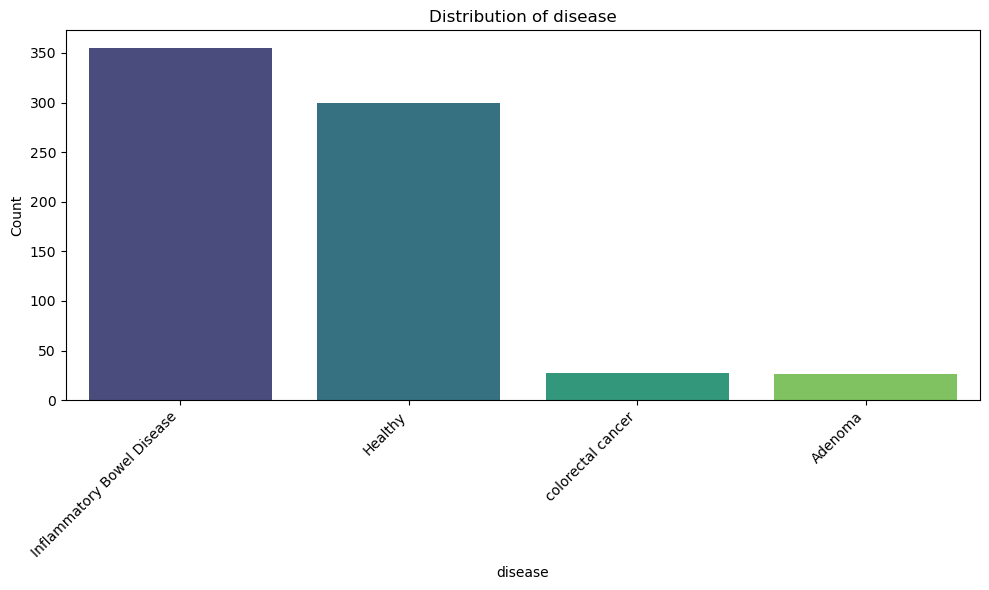

In [57]:
field_to_visualize = "disease"
disease_counts = harmonized_meta[field_to_visualize].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=disease_counts.index, y=disease_counts.values, palette="viridis")
plt.title(f"Distribution of {field_to_visualize}")
plt.xlabel(field_to_visualize)
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

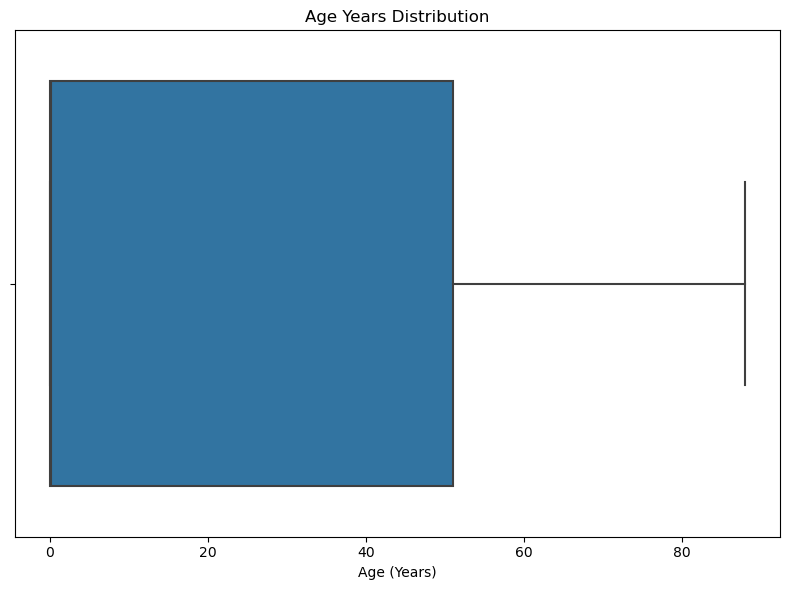

In [58]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=harmonized_meta["age_years"])
plt.title("Age Years Distribution")
plt.xlabel("Age (Years)")
plt.tight_layout()
plt.show()

---
**Work By Changchang Li**  
March 14th, 2025